# FastAI Tutorial - DataBlock

In [1]:
from fastai2.data.all import *
from fastai2.vision.all import *

## Building a DataBlock from Scratch

In [2]:
# first step is to download and decompress data
path = untar_data(URLs.PETS)

In [3]:
# get all images in the folder
fnames = get_image_files(path/'images')

In [5]:
# begin by an empty datablock
dblock = DataBlock()

> By itself, a `DataBlock` is just a blue print on how to assemble your data. It does not do anything until you pass it a source. You can choose to then convert that source into a `Datasets` or a `DataLoaders` by using the `DataBlock.datasets` or `DataBlock.dataloaders` method. Since we haven't done anything to get our data ready for batches, the dataloaders method will fail here, but we can have a look at how it gets converted in `Datasets`.

In [7]:
# convert into Datasets
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/pomeranian_15.jpg'),
 Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/pomeranian_15.jpg'))

By default, DataBlock API assumes we have an input and a target, that's why we see our filename repeated twice.

In [8]:
# use get_items function to assemble items inside the datablock
dblock = DataBlock(get_items=get_image_files)

Here, the difference is that we pass a source folder instead all of the filenames

In [9]:
dsets = dblock.datasets(path/'images')
dsets.train[0]

(Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/keeshond_25.jpg'),
 Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/keeshond_25.jpg'))

In [12]:
# convert target to "True" (cat) or "False" (dog)
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

In [14]:
# now we can tell our datablock to use it by passing get_y param
dblock = DataBlock(get_items=get_image_files, get_y=label_func)
dsets = dblock.datasets(path/'images')
dsets.train[0]

(Path('C:/Users/Archel/.fastai/data/oxford-iiit-pet/images/newfoundland_66.jpg'),
 'dog')

Now we can specify the types to tell the DataBlock API that our <b>inputs are images and targets are categories</b>

In [17]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y=label_func)

dsets = dblock.datasets(path/'images')
dsets.train[0]

(PILImage mode=RGB size=317x500, TensorCategory(1, dtype=torch.int32))

In [18]:
# create a mapping index called 'vocab' since the transformed targets are converted into tensors
dsets.vocab

(#2) ['cat','dog']

> Note that you can mix and match any block for input and targets, which is why the API is named data block API. You can also have more than two blocks (if you have multiple inputs and/or targets), you would just need to pass n_inp to the `DataBlock` to tell the library how many inputs there are (the rest would be targets) and pass a list of functions to `get_x` and/or `get_y` (to explain how to process each item to be ready for his type). See the object detection below for such an example.

In [19]:
# control how validation is created --> pass splitter to our datablock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y=label_func,
                  splitter = RandomSplitter())

dsets = dblock.datasets(path/'images')
dsets.train[0]

(PILImage mode=RGB size=500x375, TensorCategory(1, dtype=torch.int32))

In [20]:
# last step, specify item transformations and batch transforms
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y=label_func,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(224))

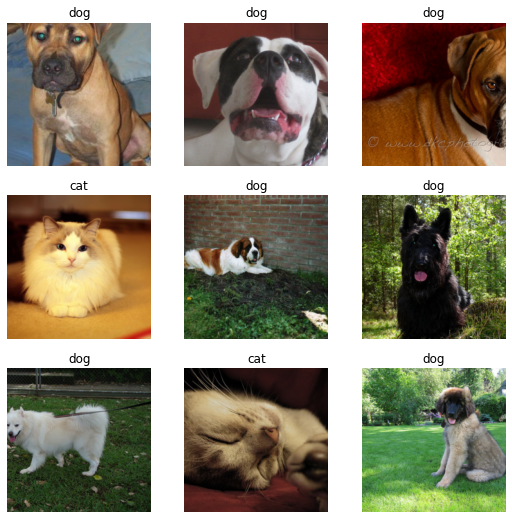

In [21]:
# now we are able to create DataLoaders object
dls = dblock.dataloaders(path/'images')
dls.show_batch()

The way we usually build the data block in one go is by answering a list of questions:
- what is the types of your inputs/targets? Here images and categories
- where is your data? Here in filenames in subfolders
- does something need to be applied to inputs? Here no
- does something need to be applied to the target? Here the label_func function
- how to split the data? Here randomly
- do we need to apply something on formed items? Here a resize
- do we need to apply something on formed batches? Here no

This gives us this design:
<code>
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))
</code>

## Image Classification

### MNIST

MNIST is a dataset of hand-written digits from 0 to 9. We can very easily load it in the data block API by answering the following questions:

- what are the types of our inputs and targets? Black and white images and labels.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? By looking at the grandparent folder.
- how do we know the label of an image? By looking at the parent folder.

In terms of the API, those answers translate like this:

In [23]:
# mnist data (single label)
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                 get_items=get_image_files,
                 splitter=GrandparentSplitter(),
                 get_y=parent_label)

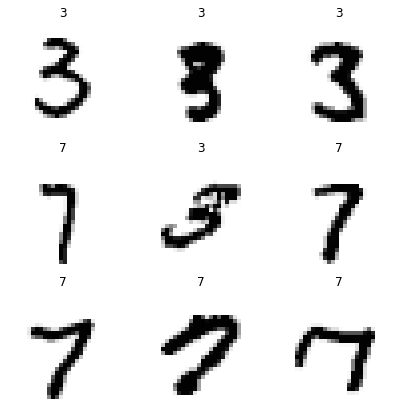

In [24]:
dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(7,7))

In [28]:
# use summary() to see what exactly happened under the hood and see a which process it failed (if it fails)
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\Archel\.fastai\data\mnist_tiny\train\3\7.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      C:\Users\Archel\.fastai\data\mnist_tiny\train\3\7.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(0, dtype=torch.int32)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(0, dtype=torch.int32))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
App

### Pets (Single Label)

In [30]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(),
                get_y=Pipeline([attrgetter("name"), RegexLabeller(pat=r'^(.*)_\d+.jpg')]), # apply regex to extract labels
                item_tfms=Resize(224), # apply resize on item level
                batch_tfms=aug_transforms()) # apply augmentation on batch level

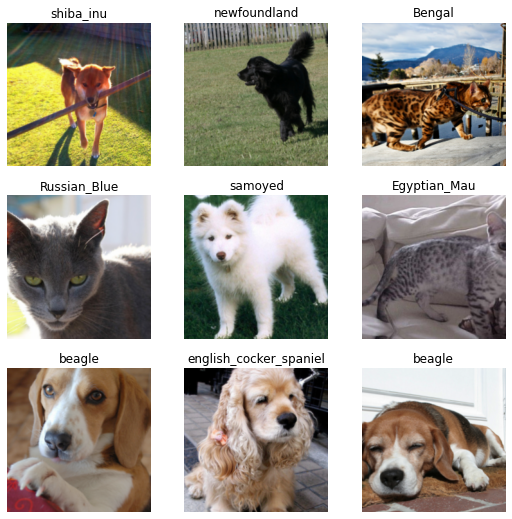

In [31]:
dls = pets.dataloaders(untar_data(URLs.PETS)/'images')
dls.show_batch(max_n=9)

### Pascal (Multi Label)

In [33]:
pascal_source = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(pascal_source/'train.csv')

In [34]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


There are multiple ways to put this in a DataBlock, let's go over them, but first, let's answer our usual questionnaire:

- what are the types of our inputs and targets? Images and multiple labels.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? A column of our dataframe.
- how do we get an image? By looking at the column fname.
- how do we know the label of an image? By looking at the column labels.
- do we want to apply a function to a given sample? Yes, we need to resize everything to a given size.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [35]:
# we won't use get_items because we already have our data in one place
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(), # default is column named "is_valid"
                   get_x=ColReader(0, pref=pascal_source/"train"), # append the source folder before the actual file name (fname)
                   get_y=ColReader(1, label_delim=' '), # 'labels' column with ' ' for splitting multiple labels
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

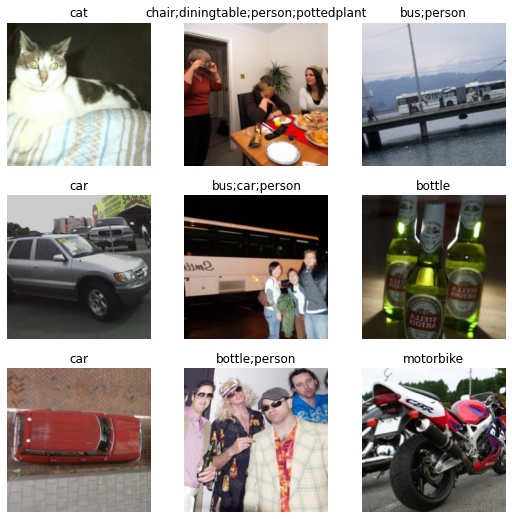

In [36]:
dls = pascal.dataloaders(df)
dls.show_batch()

Another way to do this is by directly using functions for `get_x` and `get_y`:

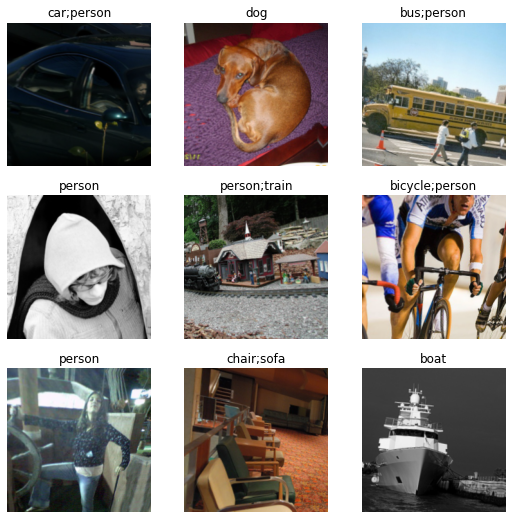

In [37]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda x:pascal_source/"train"/f'{x[0]}',
                   get_y=lambda x:x[1].split(' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

Alternatively, we can use the names of the columns as attributes (since rows of a dataframe are pandas series).

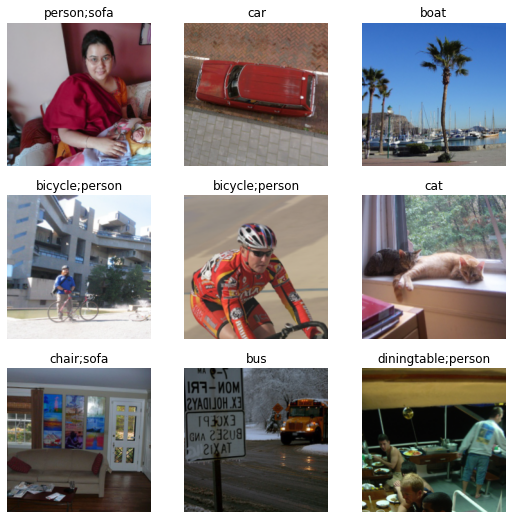

In [38]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda o:f'{pascal_source}/train/'+o.fname,
                   get_y=lambda o:o.labels.split(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

The most efficient way (to avoid iterating over the rows of the dataframe, which can take a long time) is to use the `from_columns` method. It will use `get_items` to convert the columns into numpy arrays. The drawback is that since we lose the dataframe after extracting the relevant columns, we can't use a `ColSplitter` anymore. Here we used an `IndexSplitter` after manually extracting the index of the validation set from the dataframe:

In [42]:
def _pascal_items(x): return (
    f'{pascal_source}/train/'+x.fname, x.labels.str.split())
valid_idx = df[df['is_valid']].index.values

pascal = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=IndexSplitter(valid_idx),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

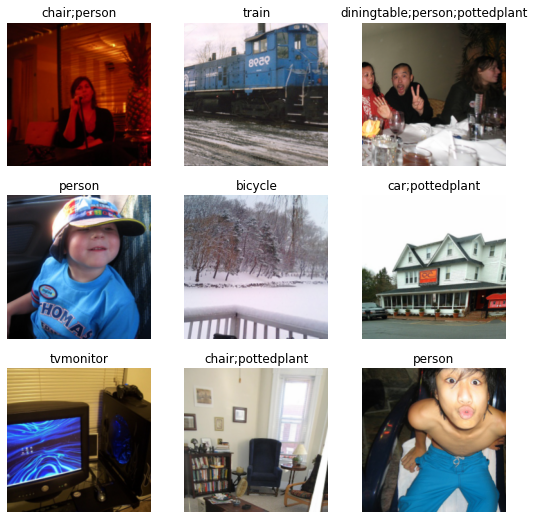

In [43]:
dls = pascal.dataloaders(df)
dls.show_batch()

## Image Localization

### Segmentation

In [44]:
# load camvid dataset
path = untar_data(URLs.CAMVID_TINY)

Let's go over our usual questionnaire:

- what are the types of our inputs and targets? Images and segmentation masks.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By looking at a corresponding file in the "labels" folder.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [45]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

The `MaskBlock` is generated with the `codes` that give the correpondence between pixel value of the masks and the object they correspond to (like car, road, pedestrian...). The rest should look pretty familiar by now.

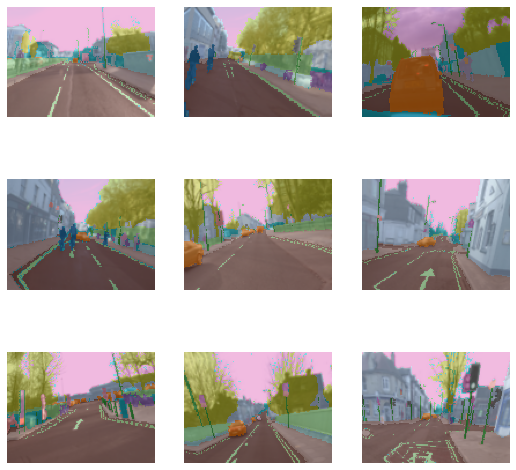

In [46]:
dls = camvid.dataloaders(path/"images")
dls.show_batch()

### Points

In [47]:
# load biwi kinnect head pose dataset
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = load_pickle(biwi_source/'centers.pkl')

NameError: name 'load_pickle' is not defined

In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

Then we can go over our usual questions:

- what are the types of our inputs and targets? Images and points.
- where is the data? In subfolders.
- how do we know if a sample is in the training or the validation set? We'll take a random split.
- how do we know the label of an image? By using the `fn2ctr` dictionary.
- do we want to apply a function to a batch after it's created? Yes, we want data augmentation.

In [ ]:
dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9)

### Bounding Boxes

In [48]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

The fastai library comes with a function called `get_annotations` that will interpret the content of `train.json` and give us a dictionary filename to (bounding boxes, labels).

In [49]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

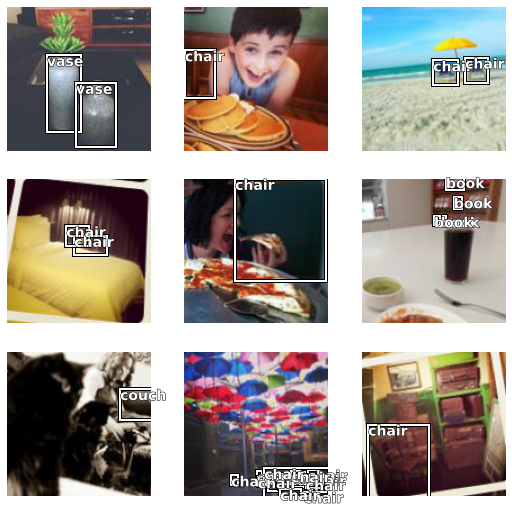

In [51]:
dls = coco.dataloaders(coco_source)
dls.show_batch()

## Text

### Language Model (No labels)

In [10]:
from fastai2.text.all import *

In [11]:
# load IMDB data
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


We can see it's composed of (pretty long!) reviews labeled positive or negative. Let's go over our usual questions:

- what are the types of our inputs and targets? Texts and we don't really have targets, since the targets is derived from the inputs.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? We have an is_valid column.
- how do we get our inputs? In the text column.

In [12]:
imdb_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True), # specify is_lm=True since we are building a language model
                   get_x=ColReader('text'),
                   splitter=ColSplitter())

Since there are no targets here, we only have one block to specify. `TextBlocks` are a bit special compared to other `TransformBlocks`: to be able to efficiently tokenize all texts during setup, you need to use the class methods `from_folder` or `from_df`.

> Note: the `TestBlock` tokenization process puts tokenized inputs into a column called text. The `ColReader` for `get_x` will always reference text, even if the original text inputs were in a column with another name in the dataframe.

In [ ]:
# then we can get our dataloaders
dls = imdb_lm.dataloaders(df, bs=16, seq_len=72)
dls.show_batch(max_n=6)

### Text Classification

For the text classification, let's go over our usual questions:

- what are the types of our inputs and targets? Texts and categories.
- where is the data? In a dataframe.
- how do we know if a sample is in the training or the validation set? We have an is_valid column.
- how do we get our inputs? In the text column.
- how do we get our targets? In the label column.

In [ ]:
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72, vocab=dls.vocab), CategoryBlock),
                     get_x=ColReader('text'),
                     get_y=ColReader('label'),
                     splitter=ColSplitter())

Like in the previous example, we use a class method to build a `TextBlock`. We can pass it the vocabulary of our language model (very useful for the ULMFit approach). We also show the `seq_len` argument (which defaults to 72) just because you need to make sure to use the same here and also in your `text_classifier_learner`.

In [ ]:
dls = imdb_clas.dataloaders(df, bs=64)
dls.show_batch()

## Tabular Data

In [2]:
from fastai2.tabular.all import *

In [3]:
# load the adult sample dataset
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In a tabular problem, we need to split the columns between the ones that represent continuous variables (like the age) and the ones that represent categorical variables (like the education):

In [4]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

In [5]:
# standard fastai preprocessing is by using pre-processors
procs = [Categorify, FillMissing, Normalize]

In [6]:
splits = RandomSplitter()(range_of(df))

In [7]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits, y_block=CategoryBlock)

We put `y_block=CategoryBlock` just to show you how to customize the block for the targets, but it's usually inferred from the data, so you don't need to pass it, normally.

In [9]:
dls = to.dataloaders()
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,61.999999,232307.999096,13.0,>=50k
1,Private,HS-grad,Never-married,Exec-managerial,Not-in-family,White,False,30.000000,347166.004155,9.0,<50k
2,Private,HS-grad,Never-married,Exec-managerial,Not-in-family,White,False,36.000000,279484.996952,9.0,<50k
3,Private,Some-college,Never-married,Sales,Own-child,White,False,24.000000,395297.004203,10.0,<50k
4,Private,11th,Married-civ-spouse,Sales,Wife,White,False,35.000000,90405.999081,7.0,<50k
5,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,False,50.000000,144361.001528,9.0,>=50k
6,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,32.000000,99309.001850,9.0,>=50k
7,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,Asian-Pac-Islander,False,28.000000,336542.996181,12.0,>=50k
8,Self-emp-not-inc,Doctorate,Never-married,Prof-specialty,Not-in-family,White,False,39.000000,164593.000647,16.0,>=50k
9,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,False,58.000000,121111.001840,9.0,<50k
